## Analysis of mutation prediction results

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import seaborn as sns

import pancancer_evaluation.config as cfg
import pancancer_evaluation.utilities.analysis_utilities as au

In [2]:
stratified_results_dir = os.path.join(cfg.results_dir, 'stratified_results', 'pancancer')
top50_results_dir = os.path.join(cfg.results_dir, 'stratified_top50', 'pancancer')

First, we load the results of stratified cross-validation experiments on the cancer genes from Vogelstein *Nature Medicine* 2004, and from the top 50 most mutated genes in TCGA.

By "stratified", we mean the train and test sets have the same proportions of each cancer type (that is, the test set contains samples from all cancer types).

In [3]:
vogelstein_df = (
    au.load_prediction_results(stratified_results_dir, 'stratified')
      .assign(gene_dataset='vogelstein')
      .drop(columns=['holdout_cancer_type', 'identifier'])
)
vogelstein_df.head()

,auroc,aupr,gene,signal,seed,data_type,fold,train_set,gene_dataset
0,0.95513,0.70461,MAP3K1,signal,42,train,0,stratified,vogelstein
1,0.69504,0.32503,MAP3K1,signal,42,test,0,stratified,vogelstein
2,0.68868,0.29750,MAP3K1,signal,42,cv,0,stratified,vogelstein
3,0.98730,0.90617,MAP3K1,signal,42,train,1,stratified,vogelstein
4,0.78217,0.42547,MAP3K1,signal,42,test,1,stratified,vogelstein


In [4]:
top50_df = (
    au.load_prediction_results(top50_results_dir, 'stratified')
      .assign(gene_dataset='top50')
      .drop(columns=['holdout_cancer_type', 'identifier'])
)
top50_df.head()

,auroc,aupr,gene,signal,seed,data_type,fold,train_set,gene_dataset
0,0.50840,0.48814,TP53,shuffled,42,train,0,stratified,top50
1,0.50625,0.47286,TP53,shuffled,42,test,0,stratified,top50
2,0.50871,0.48499,TP53,shuffled,42,cv,0,stratified,top50
3,0.50000,0.47251,TP53,shuffled,42,train,1,stratified,top50
4,0.50000,0.48817,TP53,shuffled,42,test,1,stratified,top50


Now we want to compare the results of the negative control experiments (shuffled labels) with the classifiers trained on the true labels. We can make this comparison for every gene (comparing the distribution of AUC values over cross-validation folds, using a t-test).

If the performance distributions are significantly different under the t-test, and the mean performance on the true labels is better than the mean performance on the negative control, this shows that we can successfully predict mutation status in the given gene from TCGA pan-cancer gene expression.

In [5]:
vogelstein_results_df = au.compare_results(vogelstein_df, metric='aupr', correction=True,
                                           correction_method='fdr_bh', correction_alpha=0.001,
                                           verbose=True)
vogelstein_results_df.sort_values(by='p_value').head(n=10)

shapes unequal for CBL, skipping
shapes unequal for MSH2, skipping
shapes unequal for PAX5, skipping
shapes unequal for SMO, skipping


,identifier,delta_mean,p_value,corr_pval,reject_null
76,PTEN,0.584143,5.035824e-10,3.419569e-08,True
31,ERBB2,0.576282,7.199093e-10,3.419569e-08,True
33,FBXW7,0.375389,8.646156e-09,2.178117e-07,True
10,ATRX,0.454540,9.171020e-09,2.178117e-07,True
22,CDKN2A,0.372670,2.249623e-08,4.274284e-07,True
91,TP53,0.406067,2.905414e-08,4.600238e-07,True
26,CTNNB1,0.604498,3.703337e-08,5.025958e-07,True
15,BRAF,0.602992,6.062337e-08,7.199025e-07,True
3,APC,0.587600,7.117884e-08,7.513322e-07,True
48,IDH1,0.445233,1.083661e-07,1.029478e-06,True


In [6]:
top50_results_df = au.compare_results(top50_df, metric='aupr', correction=True,
                                      correction_method='fdr_bh', correction_alpha=0.001,
                                      verbose=True)
top50_results_df.sort_values(by='p_value').head(n=10)

,identifier,delta_mean,p_value,corr_pval,reject_null
5,BRAF,0.613928,6.633317e-09,1.887473e-07,True
44,TP53,0.406135,7.549891e-09,1.887473e-07,True
2,APC,0.564998,5.604275e-08,9.340458e-07,True
36,PTEN,0.570808,1.438687e-07,1.798359e-06,True
34,PIK3CA,0.344845,2.502004e-07,2.502004e-06,True
24,KRAS,0.477475,3.672685e-06,3.060571e-05,True
42,SYNE1,0.182705,6.208411e-06,4.434579e-05,True
23,KMT2D,0.197395,7.984941e-06,4.990588e-05,True
13,DNAH7,0.170275,1.192161e-05,6.315019e-05,True
49,ZFHX4,0.177285,1.263004e-05,6.315019e-05,True


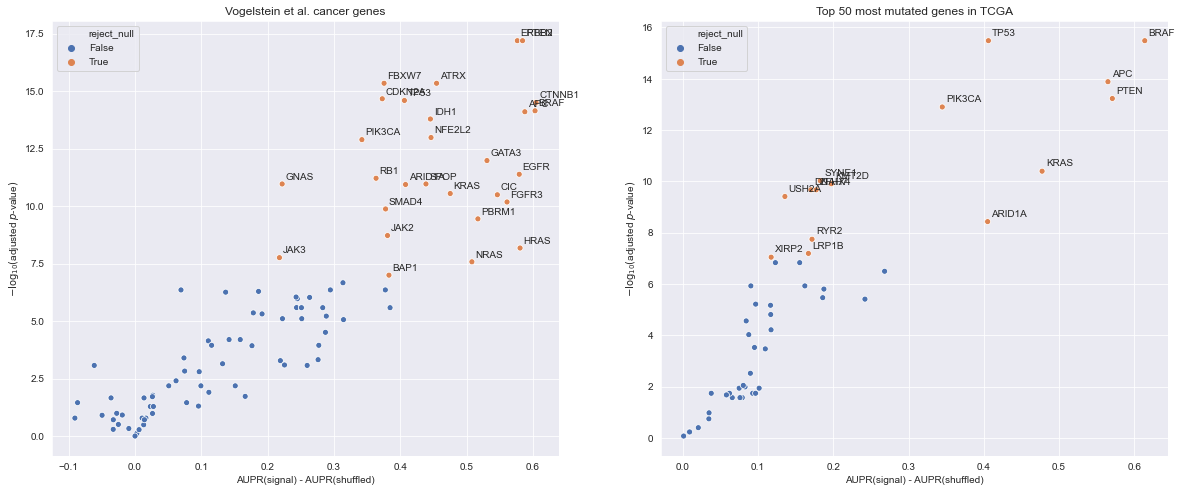

In [7]:
vogelstein_results_df['nlog10_p'] = -np.log(vogelstein_results_df.corr_pval)
top50_results_df['nlog10_p'] = -np.log(top50_results_df.corr_pval)

sns.set({'figure.figsize': (20, 8)})
fig, axarr = plt.subplots(1, 2)
sns.scatterplot(data=vogelstein_results_df, x='delta_mean', y='nlog10_p', hue='reject_null', ax=axarr[0])
axarr[0].set_xlabel('AUPR(signal) - AUPR(shuffled)')
axarr[0].set_ylabel(r'$-\log_{10}($adjusted $p$-value$)$')
axarr[0].legend()
axarr[0].set_title(r'Vogelstein et al. cancer genes')
sns.scatterplot(data=top50_results_df, x='delta_mean', y='nlog10_p', hue='reject_null', ax=axarr[1])
axarr[1].set_xlabel('AUPR(signal) - AUPR(shuffled)')
axarr[1].set_ylabel(r'$-\log_{10}($adjusted $p$-value$)$')
axarr[1].legend()
axarr[1].set_title(r'Top 50 most mutated genes in TCGA')

def label_points(x, y, gene, sig, ax):
    a = pd.DataFrame({'x': x, 'y': y, 'gene': gene, 'sig': sig})
    for i, point in a.iterrows():
        if point['sig']:
            ax.text(point['x']+.005, point['y']+.2, str(point['gene']))

label_points(vogelstein_results_df['delta_mean'], vogelstein_results_df['nlog10_p'],
             vogelstein_results_df.identifier, vogelstein_results_df.reject_null, axarr[0])
label_points(top50_results_df['delta_mean'], top50_results_df['nlog10_p'],
             top50_results_df.identifier, top50_results_df.reject_null, axarr[1])

The plot above is similar to a volcano plot used in differential expression analysis. The x-axis shows the difference between AUPR in the signal (true labels) case and in the negative control (shuffled labels) case, and the y-axis shows the negative log of the t-test p-value, after FDR adjustment.

Orange points are significant at a cutoff of $\alpha = 0.001$ after FDR correction.

In [8]:
top50_results_df[top50_results_df.identifier == 'TTN']

,identifier,delta_mean,p_value,corr_pval,reject_null,nlog10_p
45,TTN,0.242075,0.002064,0.004487,False,5.40648


We have usually used TTN as our negative control (not understood to be a cancer driver, but is a large gene that is frequently mutated as a passenger). So it's a bit weird that it has a fairly low p-value here (would be significant at $\alpha = 0.05$). We'll have to think about why this is.

## Single-cancer vs. pancancer analysis

Now, we want to look at experiments where a single cancer type is held out. We want to compare cross-validation results when models are trained only on data from a single cancer type with results when models are trained on data from all cancer types.

(All of these experiments use the Vogelstein genes, since this gene set seems to capture more relevant signal in the stratified CV results)

In [9]:
# TODO seeds can probably be merged somehow?
pancancer_dir = os.path.join(cfg.results_dir, 'pancancer')
pancancer_dir2 = os.path.join(cfg.results_dir, 'vogelstein_seed1_results', 'pancancer')
single_cancer_dir = os.path.join(cfg.results_dir, 'single_cancer')
single_cancer_dir2 = os.path.join(cfg.results_dir, 'vogelstein_seed1_results', 'single_cancer')

In [10]:
single_cancer_df1 = au.load_prediction_results(single_cancer_dir, 'single_cancer')
single_cancer_df2 = au.load_prediction_results(single_cancer_dir2, 'single_cancer')
single_cancer_df = pd.concat((single_cancer_df1, single_cancer_df2))
print(np.unique(single_cancer_df.seed))
print(single_cancer_df.shape)
single_cancer_df.head()

[ 1 42]
(20940, 10)


,auroc,aupr,gene,holdout_cancer_type,signal,seed,data_type,fold,train_set,identifier
0,0.99357,0.95200,MAP3K1,BRCA,signal,42,train,0,single_cancer,MAP3K1_BRCA
1,0.69079,0.27286,MAP3K1,BRCA,signal,42,test,0,single_cancer,MAP3K1_BRCA
2,0.74039,0.39101,MAP3K1,BRCA,signal,42,cv,0,single_cancer,MAP3K1_BRCA
3,0.99982,0.99826,MAP3K1,BRCA,signal,42,train,1,single_cancer,MAP3K1_BRCA
4,0.75636,0.62930,MAP3K1,BRCA,signal,42,test,1,single_cancer,MAP3K1_BRCA


In [11]:
pancancer_df1 = au.load_prediction_results(pancancer_dir, 'pancancer')
pancancer_df2 = au.load_prediction_results(pancancer_dir2, 'pancancer')
pancancer_df = pd.concat((pancancer_df1, pancancer_df2))
print(np.unique(pancancer_df.seed))
print(pancancer_df.shape)
pancancer_df.head()

[ 1 42]
(20760, 10)


,auroc,aupr,gene,holdout_cancer_type,signal,seed,data_type,fold,train_set,identifier
0,0.67257,0.30731,MAP3K1,BRCA,signal,42,train,0,pancancer,MAP3K1_BRCA
1,0.64775,0.30118,MAP3K1,BRCA,signal,42,test,0,pancancer,MAP3K1_BRCA
2,0.64893,0.21980,MAP3K1,BRCA,signal,42,cv,0,pancancer,MAP3K1_BRCA
3,0.99443,0.91075,MAP3K1,BRCA,signal,42,train,1,pancancer,MAP3K1_BRCA
4,0.77054,0.54482,MAP3K1,BRCA,signal,42,test,1,pancancer,MAP3K1_BRCA


In [12]:
single_cancer_comparison_df = au.compare_results(single_cancer_df,
                                                 identifier='identifier',
                                                 metric='aupr',
                                                 correction=True,
                                                 correction_alpha=0.001,
                                                 verbose=False)
single_cancer_comparison_df.sort_values(by='corr_pval').head(n=10)

,identifier,delta_mean,p_value,corr_pval,reject_null
137,CTNNB1_UCEC,0.761315,1.444065e-16,5.790699e-14,True
332,RB1_BLCA,0.657051,1.333908e-15,2.674486e-13,True
331,PTEN_UCEC,0.762998,4.466359e-15,5.970033e-13,True
79,BRAF_THCA,0.738155,8.457498e-15,8.478641e-13,True
201,IDH1_LGG,0.439180,1.168782e-14,9.373631e-13,True
288,PBRM1_KIRC,0.720956,2.195482e-14,1.467314e-12,True
56,ATRX_LGG,0.710357,1.178548e-13,6.751394e-12,True
158,ERBB2_BRCA,0.684424,1.990134e-13,8.867153e-12,True
8,APC_COAD,0.655265,1.913388e-13,8.867153e-12,True
24,ARID1A_UCEC,0.608521,2.573409e-13,1.031937e-11,True


Text(0.5, 1.0, 'Single cancer holdout, Vogelstein et al. cancer genes/TCGA cancer types')

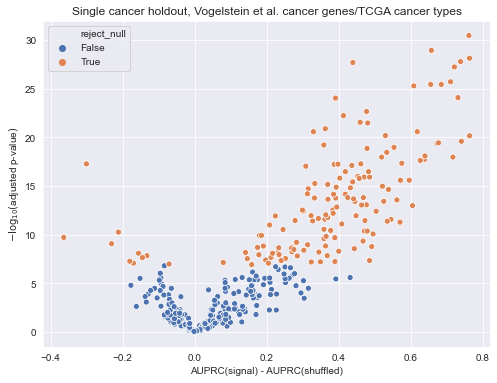

In [13]:
# volcano plot like above, but for gene/holdout cancer type combinations
# (instead of stratified CV as above)
single_cancer_comparison_df['nlog10_p'] = -np.log(single_cancer_comparison_df.corr_pval)

sns.set({'figure.figsize': (8, 6)})
sns.scatterplot(data=single_cancer_comparison_df, x='delta_mean', y='nlog10_p', hue='reject_null')
plt.xlabel('AUPRC(signal) - AUPRC(shuffled)')
plt.ylabel(r'$-\log_{10}($adjusted p-value$)$')
plt.title('Single cancer holdout, Vogelstein et al. cancer genes/TCGA cancer types')

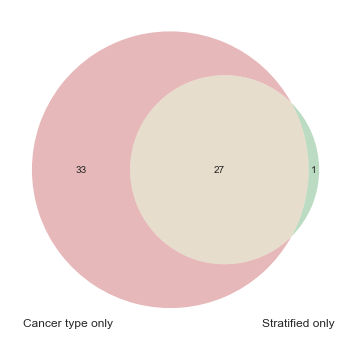

In [14]:
# get genes that are significant in single cancer holdout analysis
sig_ids = single_cancer_comparison_df[
    single_cancer_comparison_df.reject_null
].identifier.values
sig_genes = list(set([id_str.split('_')[0] for id_str in sig_ids]))

# then get overlap with genes that are significant in stratified analysis
sig_genes_stratified = vogelstein_results_df[
    vogelstein_results_df.reject_null
].identifier.values

# then plot results in a venn diagram
def get_venn(g1, g2):
    s1, s2 = set(g1), set(g2)
    s_inter = list(s1 & s2)
    s1_only = list(s1 - s2)
    s2_only = list(s2 - s1)
    return ((s1_only, s2_only, s_inter),
            (len(s1_only), len(s2_only), len(s_inter)))

venn_sets, venn_counts = au.get_venn(sig_genes, sig_genes_stratified)
v = venn2(subsets=venn_counts, set_labels=('Cancer type only', 'Stratified only', 'Both'))
v.get_label_by_id('A').set_y(-0.6)
v.get_label_by_id('B').set_y(-0.6)
v.get_label_by_id('A').set_x(-0.3)
v.get_label_by_id('B').set_x(0.3)

In [15]:
# print genes (and cancer types in holdout analysis) that are not in the intersection
holdout_only_genes = venn_sets[0]
disjoint_identifiers_df = single_cancer_comparison_df[
    (single_cancer_comparison_df.reject_null) &
    (single_cancer_comparison_df.identifier.str.startswith(tuple(holdout_only_genes)))
].sort_values(by='corr_pval').reset_index(drop=True)
print(venn_sets[1])
disjoint_identifiers_df.head(n=15)

['JAK2']


,identifier,delta_mean,p_value,corr_pval,reject_null,nlog10_p
0,KIT_TGCT,0.677021,2.050943e-10,3.575775e-09,True,19.449084
1,CDH1_BRCA,0.461297,2.770618e-09,3.107181e-08,True,17.286965
2,KDM6A_BLCA,0.387436,3.100787e-09,3.272146e-08,True,17.235235
3,JAK1_UCEC,0.470654,1.324074e-08,1.206371e-07,True,15.930479
4,FUBP1_LGG,0.571169,2.049619e-08,1.677341e-07,True,15.600886
5,CASP8_HNSC,0.432279,5.010243e-08,3.652923e-07,True,14.822568
6,STAG2_BLCA,0.424916,1.507026e-07,9.906845e-07,True,13.824870
7,STK11_LUAD,0.391472,1.663597e-07,1.042348e-06,True,13.774035
8,PPP2R1A_UCEC,0.370095,1.930102e-07,1.172683e-06,True,13.656216
9,SETD2_KIRC,0.524931,2.458635e-07,1.449872e-06,True,13.444035


In [16]:
pancancer_comparison_df = au.compare_results(pancancer_df,
                                             identifier='identifier',
                                             metric='aupr',
                                             correction=True,
                                             correction_alpha=0.001,
                                             verbose=False)
pancancer_comparison_df.sort_values(by='corr_pval').head(n=10)

,identifier,delta_mean,p_value,corr_pval,reject_null
122,CTNNB1_UCEC,0.747696,2.283201e-16,8.813158e-14,True
309,PTEN_UCEC,0.749178,1.576221e-15,3.042106e-13,True
11,APC_READ,0.752628,7.547138e-15,9.710652e-13,True
51,ATRX_LGG,0.735297,2.395309e-13,2.092726e-11,True
107,CIC_LGG,0.678060,2.710785e-13,2.092726e-11,True
146,ERBB2_ESCA,0.761216,3.625853e-13,2.332632e-11,True
143,ERBB2_BRCA,0.649181,5.474466e-13,2.641430e-11,True
71,BRAF_THCA,0.703306,4.798131e-13,2.641430e-11,True
305,PTEN_PRAD,0.615811,1.705229e-12,7.313536e-11,True
132,EGFR_LGG,0.717573,2.567462e-12,9.910403e-11,True


Text(0.5, 1.0, 'Train pan-cancer/test single cancer, Vogelstein et al. cancer genes')

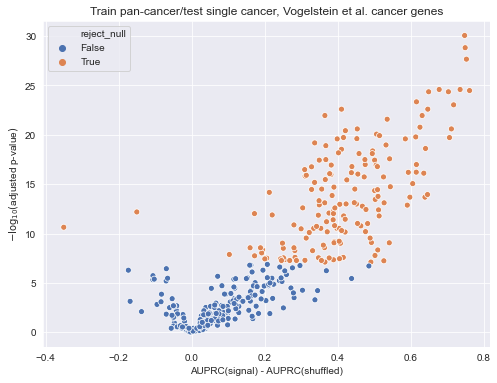

In [17]:
# TODO: Venn diagram of genes significant for stratified analysis vs. new genes
pancancer_comparison_df['nlog10_p'] = -np.log(pancancer_comparison_df.corr_pval)

sns.set({'figure.figsize': (8, 6)})
sns.scatterplot(data=pancancer_comparison_df, x='delta_mean', y='nlog10_p', hue='reject_null')
plt.xlabel('AUPRC(signal) - AUPRC(shuffled)')
plt.ylabel(r'$-\log_{10}($adjusted p-value$)$')
plt.title('Train pan-cancer/test single cancer, Vogelstein et al. cancer genes')

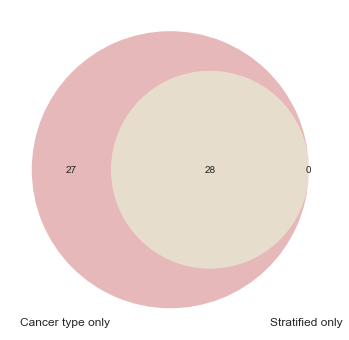

In [18]:
# get genes that are significant in single cancer holdout analysis
sig_ids = pancancer_comparison_df[
    pancancer_comparison_df.reject_null
].identifier.values
sig_genes = list(set([id_str.split('_')[0] for id_str in sig_ids]))

# then get overlap with genes that are significant in stratified analysis
sig_genes_stratified = vogelstein_results_df[
    vogelstein_results_df.reject_null
].identifier.values

# then plot results in a venn diagram
venn_sets, venn_counts = au.get_venn(sig_genes, sig_genes_stratified)
v = venn2(subsets=venn_counts, set_labels=('Cancer type only', 'Stratified only', 'Both')) 
v.get_label_by_id('A').set_y(-0.6)
v.get_label_by_id('B').set_y(-0.6)
v.get_label_by_id('A').set_x(-0.3)
v.get_label_by_id('B').set_x(0.35)

In [19]:
# print genes (and cancer types in holdout analysis) that are not in the intersection
holdout_only_genes = venn_sets[0]
disjoint_identifiers_df = pancancer_comparison_df[
    (pancancer_comparison_df.reject_null) &
    (pancancer_comparison_df.identifier.str.startswith(tuple(holdout_only_genes)))
].sort_values(by='corr_pval').reset_index(drop=True)
print(venn_sets[1])
disjoint_identifiers_df.head(n=15)

[]


,identifier,delta_mean,p_value,corr_pval,reject_null,nlog10_p
0,CDH1_BRCA,0.452599,1.969560e-10,3.041001e-09,True,19.611079
1,NF1_OV,0.505394,5.210836e-09,4.469739e-08,True,16.923351
2,RNF43_UCEC,0.309720,8.866017e-09,6.984250e-08,True,16.477023
3,NF1_PCPG,0.615230,1.174347e-08,9.065961e-08,True,16.216154
4,CASP8_HNSC,0.472699,2.282630e-08,1.468492e-07,True,15.733860
5,KDM6A_BLCA,0.336795,4.160516e-08,2.549142e-07,True,15.182339
6,H3F3A_BRCA,0.212826,1.305036e-07,6.996445e-07,True,14.172694
7,CARD11_BLCA,0.384759,1.846825e-07,9.633440e-07,True,13.852855
8,NF1_LGG,0.502823,2.893103e-07,1.431715e-06,True,13.456638
9,STK11_LUAD,0.349020,3.328740e-07,1.626448e-06,True,13.329112
